In [1]:
from datetime import datetime, timedelta

from   hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
DATA = '../data'
TODAY = datetime.now().date()
TOMORROW  = TODAY + timedelta(1)
TOMORROW

datetime.date(2022, 12, 24)

In [3]:
sp = yf.download(
    '^GSPC', start='1965-01-01', end=str(TOMORROW)).sort_index()
nyse = yf.download(
    '^NYA', start='1965-01-01', end=str(TOMORROW)).sort_index()
nas = yf.download(
    '^IXIC', start='1965-01-01', end=str(TOMORROW)).sort_index()
wil = yf.download(
    '^W5000', start='1990-01-01', end=str(TOMORROW))

path = '../data'
sp.to_csv(f'{path}/sp1950.csv')
nyse.to_csv(f'{path}/nya1965.csv')
nas.to_csv(f'{path}/nasdaq1965.csv')
wil.to_csv(f'{path}/wilshire1990.csv')

#sp = pd.read_csv(f'{DATA}/sp1950.csv')
#nyse = pd.read_csv(f'{DATA}/nya1965.csv')
#nas = pd.read_csv(f'{DATA}/nasdaq1965.csv')
#wil = pd.read_csv(f'{DATA}/wilshire1990.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
sp.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-19,3853.790039,3854.860107,3800.040039,3817.659912,3817.659912,3969610000
2022-12-20,3810.469971,3838.239990,3795.620117,3821.620117,3821.620117,3985370000
2022-12-21,3839.489990,3889.820068,3839.489990,3878.439941,3878.439941,3775200000
2022-12-22,3853.260010,3853.260010,3764.489990,3822.389893,3822.389893,3956950000
2022-12-23,3815.110107,3845.800049,3797.010010,3844.820068,3844.820068,1574704000


In [5]:
x = sp['Adj Close'].to_numpy()
np.append([np.nan], x[1:] / x[:-1])

array([       nan, 1.00474883, 1.00307222, ..., 1.01486799, 0.9855483 ,
       1.0058681 ])

In [6]:
def get_daily_changes(series):
    x = series.to_numpy()
    return np.append([1], x[1:] / x[:-1])

In [7]:
def prep_df(df, name):
    df.index = pd.to_datetime(df.index)
    df[f'{name}_daily'] = get_daily_changes(df['Adj Close'])
    df.rename(columns={'Adj Close': name}, inplace=True)
    return df[[name, f'{name}_daily']]

In [8]:
[sp, nyse, nas, wil] = [
    prep_df(df, name) 
    for df, name in zip(
        [sp, nyse, nas, wil], ['sp', 'nyse', 'nas', 'wil'])]
sp.head()

,sp,sp_daily
Date,,
1965-01-04,84.230003,1.000000
1965-01-05,84.629997,1.004749
1965-01-06,84.889999,1.003072
1965-01-07,85.260002,1.004359
1965-01-08,85.370003,1.001290


In [9]:
nyse.head()

,nyse,nyse_daily
Date,,
1965-12-31,528.690002,1.000000
1966-01-03,527.210022,0.997201
1966-01-04,527.840027,1.001195
1966-01-05,531.119995,1.006214
1966-01-06,532.070007,1.001789


In [10]:
nas.head()

,nas,nas_daily
Date,,
1971-02-05,100.000000,1.000000
1971-02-08,100.839996,1.008400
1971-02-09,100.760002,0.999207
1971-02-10,100.690002,0.999305
1971-02-11,101.449997,1.007548


In [11]:
def find_best_mod(daily, n_states=[6, 7, 8], max_iter=1000, reps=3):
    daily = np.reshape(daily.values, [-1, 1])
    best_logprob = -np.inf
    best_mod = None
    for states in n_states:
        for rep in range(reps):
            try:
                print(f'rep {rep + 1}', end='\r')
                for cov in ['spherical', 'diag', 'full']:
                    mod = GaussianHMM(
                        n_components=states, covariance_type=cov, n_iter=max_iter
                    ).fit(daily)
                    logprob = mod.score(daily)
                    if logprob > best_logprob:
                        print(f'New best - States: {states} (cov: {cov})')
                        best_logprob = logprob
                        best_mod = mod
            except ValueError:
                pass
    return best_mod

In [12]:
def get_preds(daily, mod):
    daily = np.reshape(daily.values, [-1, 1])
    states = mod.predict(daily)
    means = np.squeeze(mod.means_)
    sds = np.squeeze(np.sqrt(mod.covars_))
    preds = np.array([means[state] for state in states])
    ses = np.array([1.96 * sds[state] for state in states])
    return preds, ses, means, states[-1]

In [13]:
def plot_mod(df, preds, ses, name):
    daily = f'{name}_daily'
    plt.plot(df[daily], label='daily')
    plt.plot(df.index, preds, label='preds')
    plt.legend()

    plt.figure()
    plt.plot(df[daily], label='daily')
    plt.axhline(y=1, color='k')
    plt.plot(
        df.index, preds, label='preds', color='orange', linewidth=3)
    plt.plot(df.index, preds + ses, color='orange', linestyle='-.')
    plt.plot(df.index, preds - ses, color='orange', linestyle='-.')
    plt.ylim([0.95, 1.05]);
    plt.xlim([df.index[-500], df.index[-1]])

    plt.figure()
    plt.plot(df[name])
    plt.xlim([df.index[-500], df.index[-1]])
    sub = df.iloc[-500:, :]
    plt.ylim(
        0.95 * sub[name].min(), 1.05 * sub[name].max());

In [14]:
def get_expected_val(mod, current_state, means):
    return np.dot(mod.transmat_[current_state, :], means)

## S&P

New best - States: 3 (cov: spherical)
New best - States: 3 (cov: diag)
New best - States: 3 (cov: full)
New best - States: 4 (cov: spherical)
New best - States: 4 (cov: diag)
New best - States: 4 (cov: diag)
New best - States: 4 (cov: spherical)
New best - States: 4 (cov: diag)
0.9999492997267124


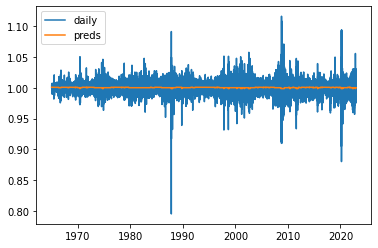

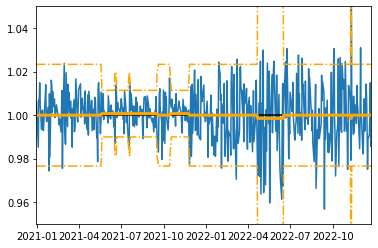

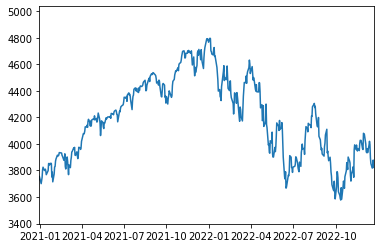

In [15]:
sp_mod = find_best_mod(sp.sp_daily, n_states=[3, 4, 5, 6])
sp_preds, sp_ses, sp_means, sp_current = get_preds(sp.sp_daily, sp_mod)
plot_mod(sp, sp_preds, sp_ses, 'sp')
sp_exp = get_expected_val(sp_mod, sp_current, sp_means)
print(sp_exp)

## NYSE

New best - States: 5 (cov: spherical)
New best - States: 5 (cov: diag)
New best - States: 5 (cov: full)
New best - States: 5 (cov: diag)
New best - States: 6 (cov: spherical)
New best - States: 7 (cov: spherical)
New best - States: 7 (cov: diag)
New best - States: 7 (cov: diag)
New best - States: 7 (cov: full)
1.0000340843908146


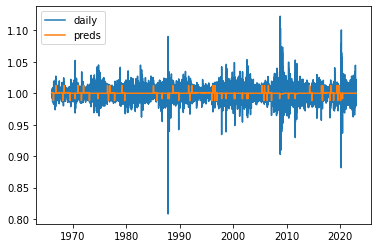

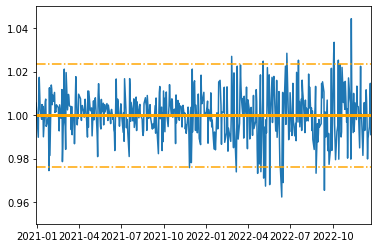

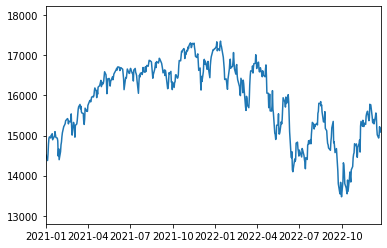

In [16]:
nyse_mod = find_best_mod(nyse.nyse_daily, n_states=[5, 6, 7, 8])
nyse_preds, nyse_ses, nyse_means, nyse_current = get_preds(
    nyse.nyse_daily, nyse_mod)
plot_mod(nyse, nyse_preds, nyse_ses, 'nyse')
nyse_exp = get_expected_val(nyse_mod, nyse_current, nyse_means)
print(nyse_exp)

## Nasdaq

New best - States: 8 (cov: spherical)
New best - States: 8 (cov: diag)
New best - States: 8 (cov: full)
New best - States: 9 (cov: spherical)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


New best - States: 9 (cov: spherical)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:306: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /


1.000408569727181


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


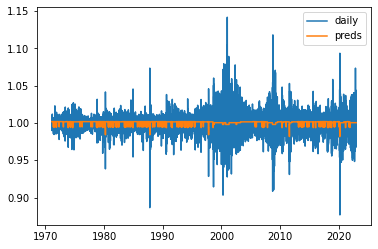

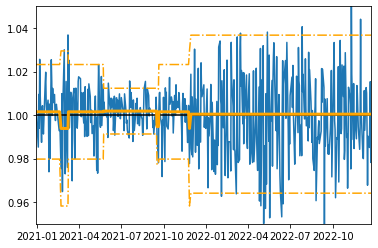

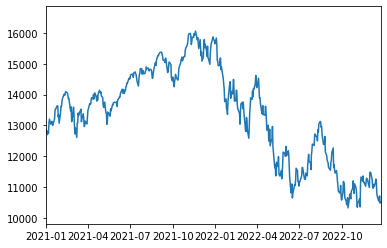

In [17]:
nas_mod = find_best_mod(nas.nas_daily, n_states=[8, 9, 10])
nas_preds, nas_ses, nas_means, nas_current = get_preds(
    nas.nas_daily, nas_mod)
plot_mod(nas, nas_preds, nas_ses, 'nas')
nas_exp = get_expected_val(nas_mod, nas_current, nas_means)
print(nas_exp)

## Wilshire

New best - States: 7 (cov: spherical)
New best - States: 7 (cov: diag)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:306: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /


New best - States: 9 (cov: spherical)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


1.0003884353590238


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


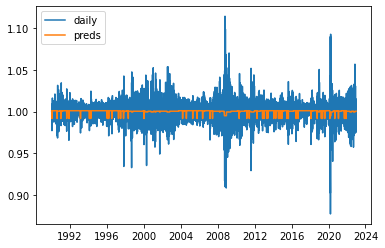

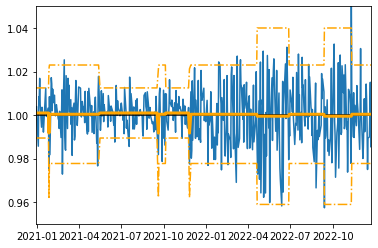

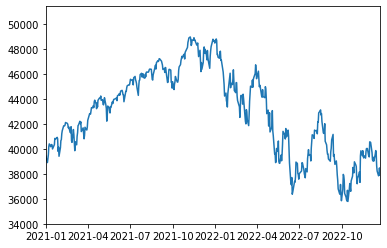

In [18]:
wil_mod = find_best_mod(wil.wil_daily, n_states=[7, 8, 9, 10])
wil_preds, wil_ses, wil_means, wil_current = get_preds(
    wil.wil_daily, wil_mod)
plot_mod(wil, wil_preds, wil_ses, 'wil')
wil_exp = get_expected_val(wil_mod, wil_current, wil_means)
print(wil_exp)

In [19]:
mean_states = (4 + 7 + 9 + 9) / 4
mean_states

7.25

In [20]:
N_STATES = 7

In [21]:
exp = (sp_exp + nyse_exp + nas_exp + wil_exp) / 4
exp

1.0001950973009328

In [22]:
for df, name, exp in zip(
        [sp, nyse, nas, wil],
        ['sp', 'nyse', 'nas', 'wil'],
        [sp_preds, nyse_preds, nas_preds, wil_preds]):
    df[f'{name}_exp'] = exp

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_50294/3186342578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{name}_exp'] = exp


In [23]:
df = pd.concat([sp, nyse, nas, wil], axis=1)
df.tail()

,sp,sp_daily,sp_exp,nyse,nyse_daily,nyse_exp,nas,nas_daily,nas_exp,wil,wil_daily,wil_exp
Date,,,,,,,,,,,,
2022-12-19,3817.659912,0.990992,0.999948,14938.030273,0.994664,0.999863,10546.030273,0.985112,1.000421,37834.230469,0.989984,1.000382
2022-12-20,3821.620117,1.001037,0.999948,15000.620117,1.004190,0.999863,10547.110352,1.000102,1.000421,37891.238281,1.001507,1.000382
2022-12-21,3878.439941,1.014868,0.999948,15219.549805,1.014595,0.999863,10709.370117,1.015384,1.000421,38462.921875,1.015087,1.000382
2022-12-22,3822.389893,0.985548,0.999948,15081.530273,0.990931,0.999863,10476.120117,0.978220,1.000421,37899.750000,0.985358,1.000382
2022-12-23,3844.820068,1.005868,0.999948,15174.526367,1.006166,0.999863,10497.863281,1.002075,1.000421,38073.144531,1.004575,1.000382


In [24]:
df['mean_exp'] = (
    df[['sp_exp', 'nyse_exp', 'nas_exp', 'wil_exp']].mean(axis=1))

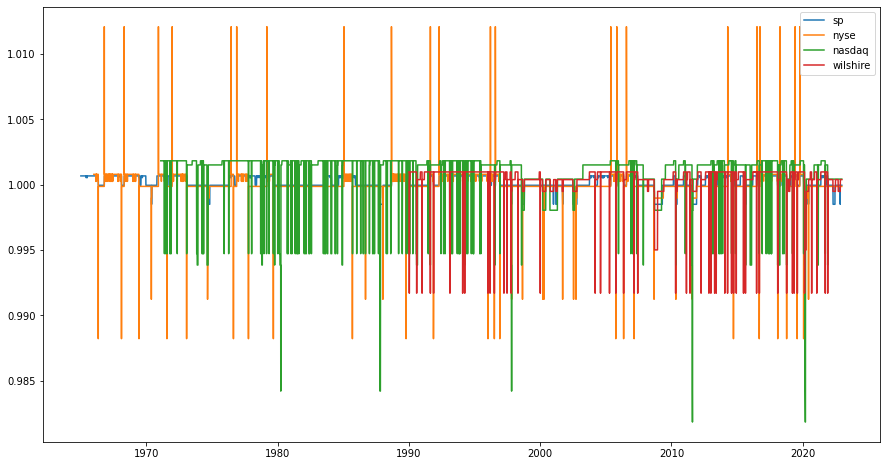

In [25]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, label='sp')
plt.plot(df.nyse_exp, label='nyse')
plt.plot(df.nas_exp, label='nasdaq')
plt.plot(df.wil_exp, label='wilshire')

plt.legend();

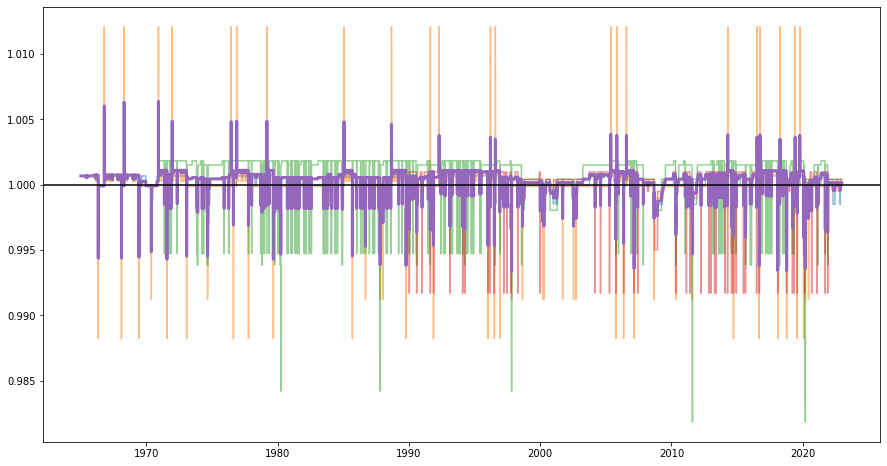

In [26]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.axhline(y=1, color='k');

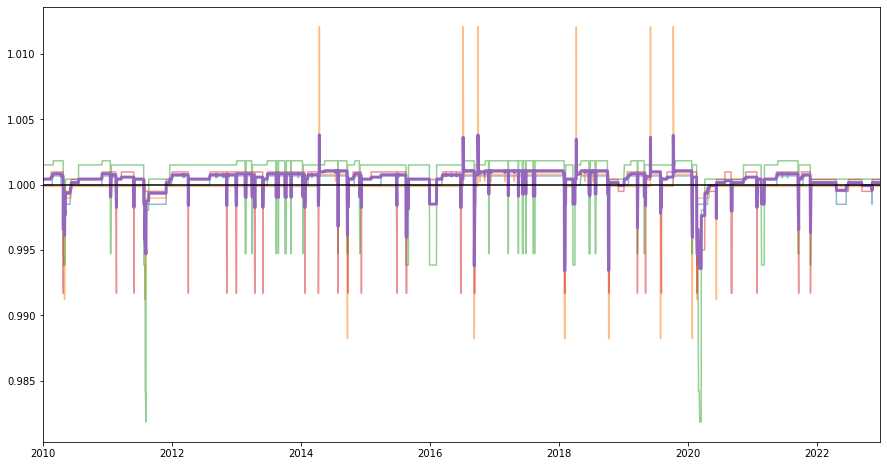

In [27]:
TODAY = datetime.now()
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.axhline(y=1, color='k')
plt.xlim(pd.to_datetime('2010-01-01'), TODAY);

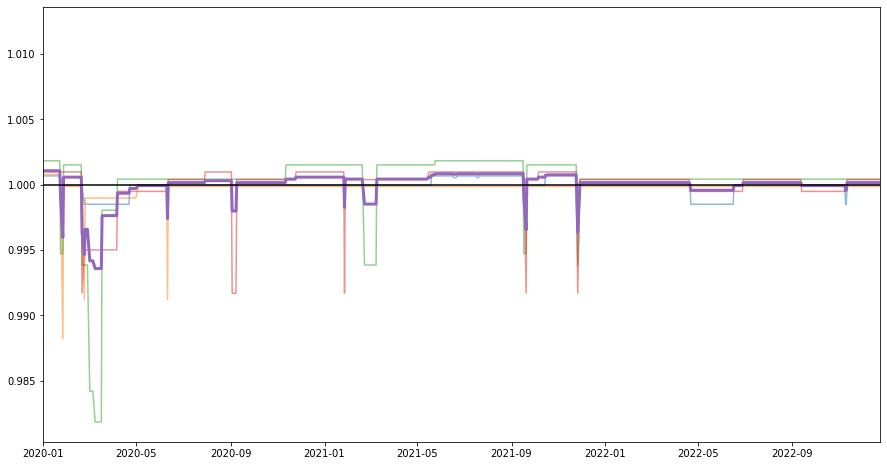

In [28]:
TODAY = datetime.now()
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.xlim(pd.to_datetime('2020-01-01'), TODAY);
plt.axhline(y = 1, color='k');

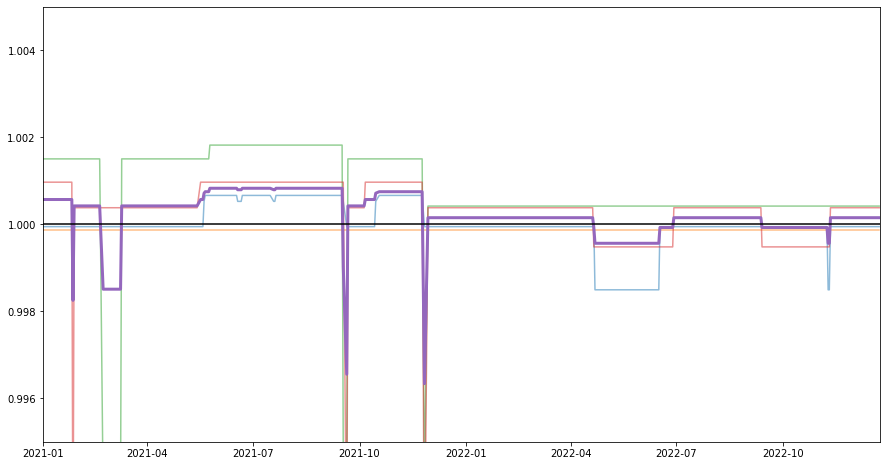

In [29]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.axhline(y=1, color='k')
plt.xlim(pd.to_datetime('2021-01-01'), TODAY)
plt.ylim([0.995, 1.005]);


In [30]:
df = df[df.index >= pd.to_datetime('1970-01-01')]

In [31]:
df.mean_exp.quantile(np.linspace(0, 1, 8))

0.000000    0.993350
0.142857    1.000153
0.285714    1.000425
0.428571    1.000544
0.571429    1.000571
0.714286    1.000796
0.857143    1.001061
1.000000    1.006375
Name: mean_exp, dtype: float64

In [32]:
try:
    df['state'] = pd.qcut(
        df.mean_exp, N_STATES, retbins=False, duplicates='drop', labels=range(N_STATES))
except ValueError:
    df['state'] = pd.qcut(
        df.mean_exp, N_STATES, retbins=False, duplicates='drop', labels=range(N_STATES - 1))

In [33]:
df.state.value_counts()

0    3222
5    2634
2    2523
4    1685
1    1476
6    1181
3     644
Name: state, dtype: int64

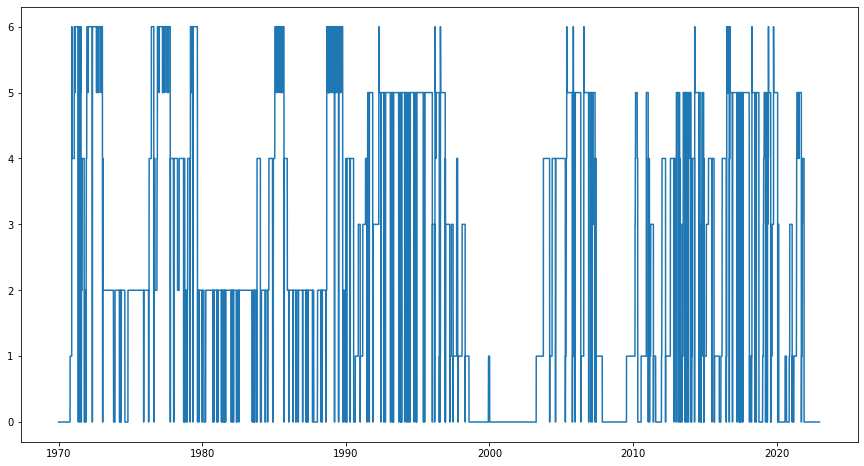

In [34]:
plt.figure(figsize=[15, 8])
plt.plot(df.state);

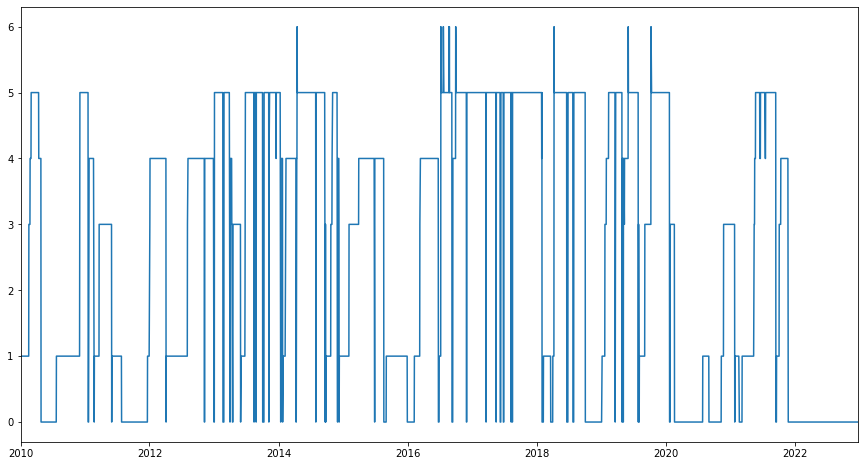

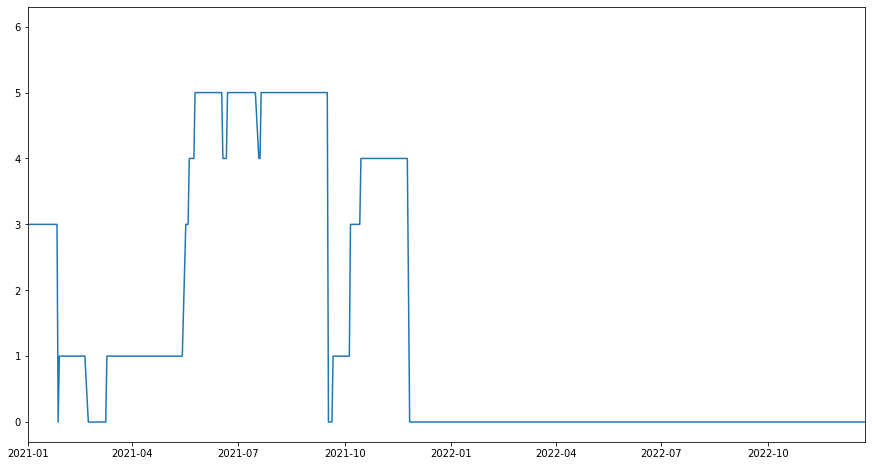

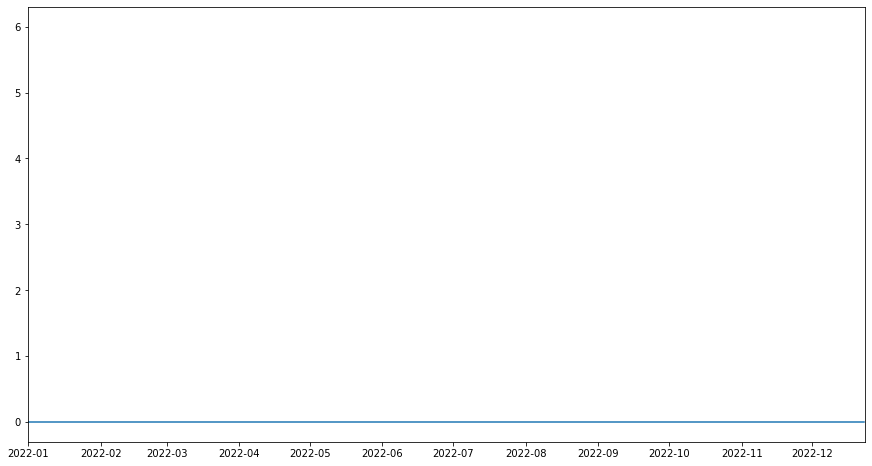

In [35]:
plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2010-01-01'), TODAY);

plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2021-01-01'), TODAY);

plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2022-01-01'), TODAY);

In [36]:
df.to_csv(f'{DATA}/hmm_exp_returns.csv')

In [37]:
TODAY

datetime.datetime(2022, 12, 23, 13, 13, 56, 85061)

In [38]:
df.state[-1]

0